# string GA - Hill climbing
## With Round-robin / FiFo

In [16]:
import numpy as np
from rl.environments.NewConveyor1GA import NewConveyor1GA
import yaml
import random
from copy import copy
import time
import plotly.express as px
import statistics as sts
import matplotlib.pyplot as plt

def single_point_crossover(input_list):
    """Changes a string with one-point cross-over to a new string"""
    new_list = copy(input_list)
    i1 = random.randint(1,len(new_list)-1)
    i2 = random.randint(1,len(new_list)-1)
    t1 = new_list[i1]
    t2 = new_list[i2]
#     print('t1 = {} and t2 = {}'.format(t1,t2))
    while t1 == t2:
#         print('in while loop')
        i1 = random.randint(1,len(new_list)-1)
        i2 = random.randint(1,len(new_list)-1)
        t1 = new_list[i1]
        t2 = new_list[i2]
#         print('t1 = {} and t2 = {}'.format(t1,t2))
    new_list[i1] = t2
    new_list[i2] = t1
    return new_list

def mutate(input_list, amount_of_actions, mutation_percentage=0.15):
    """Mutates an item in a list to an new variable."""
    new_list = copy(input_list)
    if random.random() < mutation_percentage:
        i1 = random.randint(0,len(new_list)-1)
        list_of_options = [item for item in range(amount_of_actions) if item != new_list[i1]]
        new_list[i1] = list_of_options[random.randint(0,len(list_of_options)-1)]        
    return new_list

def smooth(scalars, weight):
    """
    Smoothes the datapoints
    :param scalars: list with datapoints
    :param weight: float between 0 and 1, how smooth
    :return: the smoothed data points
    """
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)  # Save it
        last = smoothed_val  # Anchor the last smoothed value
    return smoothed

def matplot_data(training_data, fitness, smoothing=0.96):
    """builds matplotlib figure of the data"""
    plt.style.use('ggplot')
    plt.figure(figsize=(15, 5))
    line1 = plt.plot([i for i in range(len(training_data))], training_data , color ='#f9d1b3', alpha=0.7, label='Reward')
    line2 = plt.plot([i for i in range(len(training_data))], smooth(training_data, smoothing) , color ='#f06d07', label='Smoothed reward: {}'.format(smoothing))
    plt.plot([i for i in range(len(training_data))], fitness , color ='grey', alpha=0.6, label='Highest reward')
    plt.xlabel('Timestep')
    plt.ylabel('Episode Reward')
    plt.legend()
    #plt.grid(color='grey')
    #plt.axhline(color='black')
    plt.show()

def return_fitness(order_list):
    """"Calculates the fitness of an order set"""""
    env.reset()
    for item in order_list:
        env.step(item)
        #env.render()
    while not env.terminate:
        env.step(0)
        #env.render()
    return env.episode_reward, env.cycle_count

#### Initialize the sequence and the environment
config_path = 'rl/config/NewConveyor1GA.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
    
queues = [random.choices(np.arange(1,config['environment']['amount_output']+1), [config['environment']['percentage_small_carriers'], config['environment']['percentage_medium_carriers'], config['environment']['percentage_large_carriers']], k=config['environment']['gtp_buffer_size']) for item in range(config['environment']['amount_of_gtps'])] # generate random queues
#queues = [[2, 1, 2, 1, 2, 2, 1, 2, 1, 2],[1 , 2, 1, 2, 2, 2, 1, 2, 2, 1],[ 1, 2, 2, 1, 2, 2, 2, 2, 1, 2]]
env = NewConveyor1GA(config, queues)


#### build order list
orderlist = [[[item[index]*env.amount_of_gtps+env.queues.index(item)-1] +[0]*18 for item in env.queues] for index in range(len(env.queues[0]))]
orderlist = [item for sublist in orderlist for item in sublist]
orderlist = [item for sublist in orderlist for item in sublist]
orderlist = orderlist[6*env.amount_of_gtps*env.amount_of_outputs:]
return_fitness(orderlist)

INFO:root:queues that are initialized: [[2, 3, 2, 1, 2, 3, 1, 1, 2, 1], [2, 3, 1, 3, 3, 3, 1, 1, 2, 2]]


Terminate on cycle count: 0.000


(-33575, 251)

In [17]:
#### Calculate best sequence
fitness = []
training_data = []
t = 0
window = 200
order_list = orderlist
best_run, _ = return_fitness(order_list)
fitness.append(best_run)
training_data.append(best_run)
start = time.time()
for i in range(window):
    t+=1
    new_order_list = single_point_crossover(order_list)
    new_order_list = mutate(new_order_list, env.action_space.n)
    this_run, _ = return_fitness(new_order_list)
    #print('Reward run no: {} : {} '.format(t, this_run))
    if this_run > best_run:
        order_list = new_order_list
        best_run = this_run
        print('Order list updated, best reward: {}'.format(best_run), end = '\r')
    fitness.append(best_run)
    training_data.append(this_run)
    
while sts.mean(fitness[-window:]) != max(fitness):
    t+=1
    new_order_list = single_point_crossover(order_list)
    new_order_list = mutate(new_order_list, env.action_space.n)
    this_run, _ = return_fitness(new_order_list)
    #print('Reward run no: {} : {} '.format(t, this_run))
    if this_run > best_run:
        order_list = new_order_list
        best_run = this_run
        print('Order list updated, best reward: {}'.format(best_run), end = '\r')
    fitness.append(best_run)
    training_data.append(this_run)
delta = time.time() - start
print('Running time: {} minutes'.format(delta/60))
print('Best reward: {} \n Resulting sequence of actions: \n {}'.format(best_run, order_list))

Terminate on cycle countR: -10.000
Terminate on cycle countR: -10.000
Terminate on cycle countR: -10.00033970
Terminate on cycle countR: -10.000
Terminate on cycle count: -10.000-1420
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.0000
Terminate on cycle countR: -10.000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.000-1400
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.000-1040
Terminate on cycle count: -10.0000
Terminate on cycle countR: -10.000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.000-875
Terminate on cycle countR: -10.000
Terminate on cycle count: -10.0000
Terminate on cycle count: -10.0000


In [18]:
# plot a figure with the reward over time
smooth_fit = smooth(training_data, 0.96)
fig = px.line(x=[i for i in range(len(fitness))], y=[training_data, smooth_fit], title='Reward')
fig.show()

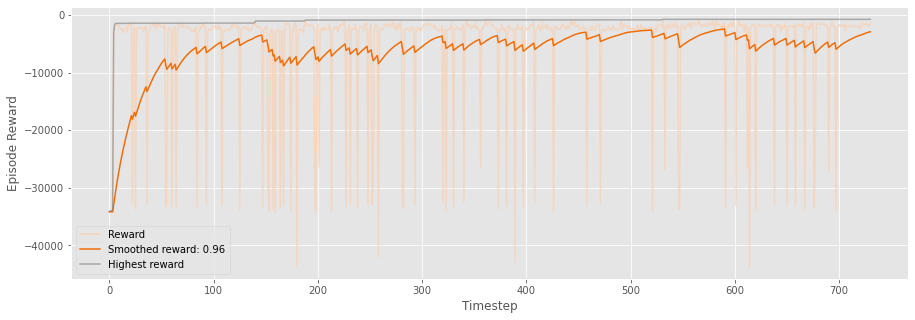

In [19]:
matplot_data(training_data, fitness, smoothing=0.96)

In [22]:
# To record info about this session
env.reset()
info = []
for item in order_list:
    _, _,_, inf = env.step(item)
    info.append(inf)
while not env.terminate:
    _, _,_, inf = env.step(0)
    info.append(inf)

In [23]:
info[-1]

{'items_processed': 18, 'cycle count': 15}

In [14]:
15/18

0.8333333333333334

In [79]:
# and show the best one
env.reset()
for item in order_list:
    env.step(item)
    env.render()
while env.terminate:
    env.step(0)
    env.render()

KeyboardInterrupt: 

## With Random shuffle

In [4]:
import random

#queues = [random.choices(np.arange(1,config['environment']['amount_gtp']+1), [config['environment']['percentage_small_carriers'], config['environment']['percentage_medium_carriers'], config['environment']['percentage_large_carriers']], k=config['environment']['gtp_buffer_size']) for item in range(config['environment']['amount_gtp'])] # generate random queues
queues = [[2, 3, 2, 1, 3, 2, 3, 3, 3, 2], [3, 2, 3, 2, 2, 3, 1, 2, 2, 3], [2, 2, 1, 2, 2, 3, 2, 3, 2, 3]]
env = simple_conveyor_2(config, queues)


#### build order list
order_list = [item for sublist in queues for item in sublist]
order_list = order_list + 3*len(order_list) * [0]
random.shuffle(order_list)


#### Calculate best sequence
fitness = []
t = 0
best_run = return_fitness(order_list)
fitness.append(best_run)
start = time.time()
for i in range(100):
    t+=1
    new_order_list = single_point_crossover(order_list)
    this_run = return_fitness(new_order_list)
    if this_run > best_run:
        order_list = new_order_list
        best_run = this_run
        print('Order list updated, best reward: {}'.format(best_run), end = '\r')
    fitness.append(best_run)
    
while sts.mean(fitness[-100:]) != max(fitness):
    t+=1
    new_order_list = single_point_crossover(order_list)
    this_run = return_fitness(new_order_list)
    if this_run > best_run:
        order_list = new_order_list
        best_run = this_run
        print('Order list updated, best reward: {}'.format(best_run), end = '\r')
    fitness.append(best_run)
delta = time.time() - start
print('Running time: {} minutes'.format(delta/60))
print('Best reward: {} \n Resulting sequence of actions: \n {}'.format(best_run, order_list))

Running time: 1.3242611010869345 minutes
Best reward: 466 
 Resulting sequence of actions: 
 [0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 2, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 1, 2, 0, 0, 2, 3, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 3]


In [5]:
# plot a figure with the reward over time
fig = px.line(x=[i for i in range(len(fitness))], y=fitness, title='Reward')
fig.show()

In [6]:
# and show the best one
env.reset()
for item in order_list:
    env.step(item)
    env.render()
while env.demand_queues != [[] * i for i in range(env.amount_of_gtps)]:
    env.step(0) 
    env.render()

# Random restart + Hill climbing

# Tabu Search: hill climbing by local search

# Other

In [12]:
order_list = []
for index in range(len(queues[0])):
    order_list.append([item[index] for item in env.queues])

#flat_list = [item for sublist in l for item in sublist]
order_list = [item for sublist in order_list for item in sublist]
#print(order_list)
order_list = order_list + 2*len(order_list) * [0]
#print(order_list)

In [13]:
import time
fitness = []
t = 0
best_run = return_fitness(order_list)
start = time.time()
for i in range(1000):
    t+=1
    new_order_list = single_point_crossover(order_list)
    this_run = return_fitness(new_order_list)
    if this_run > best_run:
        order_list = new_order_list
        best_run = this_run
        print('Order list updated, best reward: {}'.format(best_run), end = '\r')
        fitness.append([t, best_run])
delta = time.time() - start
print('Running time: {} minutes'.format(delta/60))
print('Best reward: {} \n Resulting sequence of actions: \n {}'.format(best_run, order_list))

Running time: 7.839385946591695 minutes
Best reward: 468 
 Resulting sequence of actions: 
 [2, 2, 2, 3, 3, 2, 0, 3, 0, 3, 1, 2, 0, 2, 3, 0, 2, 2, 2, 0, 0, 1, 2, 2, 2, 0, 3, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 2]


In [67]:
import numpy as np
from SC_v12 import simple_conveyor_2
import yaml
import random
from copy import copy


def single_point_crossover(input_list):
    """Changes a string with one-point cross-over to a new string"""
    new_list = copy(input_list)
    i1 = random.randint(1,len(new_list)-1)
    i2 = random.randint(1,len(new_list)-1)
    t1 = new_list[i1]
    t2 = new_list[i2]
    print('t1 = {} and t2 = {}'.format(t1,t2))
    while t1 == t2:
        print('in while loop')
        i1 = random.randint(1,len(new_list)-1)
        i2 = random.randint(1,len(new_list)-1)
        t1 = new_list[i1]
        t2 = new_list[i2]
        print('t1 = {} and t2 = {}'.format(t1,t2))
    new_list[i1] = t2
    new_list[i2] = t1
    return new_list

order_list = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [74]:
print(order_list)

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [73]:
print(single_point_crossover(order_list))

t1 = 1 and t2 = 0
[1, 0, 1, 0, 0, 0, 0, 1, 0, 0]


In [5]:
def return_fitness(order_list):
""""Calculates the fitness of an order set"""""
    env.reset()
    for item in order_list:
        env.step(item)
    while env.demand_queues != [[] * i for i in range(env.amount_of_gtps)]:
        env.step(0) 
    return env.reward

INFO:root:setup used: [[2, 3, 2, 1, 3, 2, 3, 3, 3, 2], [3, 2, 3, 2, 2, 3, 1, 2, 2, 3], [2, 2, 1, 2, 2, 3, 2, 3, 2, 3]]


297

In [9]:
env.negative_reward

-340

In [ ]:
env.reset()
for item in order_list:
    env.step(item)
    env.render()
while env.demand_queues != [[] * i for i in range(env.amount_of_gtps)]:
    env.step(0) 
    env.render()
env.negative_reward

INFO:root:0


INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
INFO:root:0
